# exp062
exp60base  
w2v 類似度

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import polars as pl
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [2]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp062"
    run_inf = False
    seed = 42
    k = 20
    cand_n = 15
    negative_sample = 1
    train_chunk_n_dict = {"clicks":2, "carts":1, "orders":1}
    test_chunk_n = 5
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_week = "week3"
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

    clicks_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 5.485903737168179, 'lambda_l2': 0.005594683492536064, 'num_leaves': 79, 'feature_fraction': 0.552, 'bagging_fraction': 0.9295272232672004, 'bagging_freq': 2, 'min_child_samples': 10}
    carts_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 8.709050252544463, 'lambda_l2': 0.06935262036337767, 'num_leaves': 252, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
    orders_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 9.356310279757256, 'lambda_l2': 1.3120983078968551e-08, 'num_leaves': 174, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [3]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*"))

    def update(self):
        self.caches = list(self.cache_dir_path.glob("*"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, filename))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        self.update()
        return len([str(c) for c in self.caches if path == str(c)]) > 0

cache = Cache()

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == np.ndarray:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == np.ndarray:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".6f")
    results["recall_carts"] = format(recall_carts, ".6f")
    results["recall_orders"] = format(recall_orders, ".6f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".6f")
    results["w_recall_carts"] = format(w_recall_carts, ".6f")
    results["w_recall_orders"] = format(w_recall_orders, ".6f")
    results["score"] = format(score, ".6f")

    return results

In [6]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pl_df):
        self.df = cudf.from_pandas(pl_df.to_pandas())
        self.sessions = []
        self.aids = []

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[add_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        elif strategy == "repurchase":
            candidate_df = self._repurchase(candidate_df)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map).astype("int32")
            candidate_df = candidate_df.dropna(subset=["aid"])
        candidate_df = candidate_df.drop_duplicates(subset=["session", "aid"])
        
        self.sessions.extend(candidate_df["session"].to_arrow().to_pylist())
        self.aids.extend(candidate_df["aid"].to_arrow().to_pylist())

    @noglobal(excepts=["cfg", "logger"])
    def get_dataframe(self):
        cand_df = pl.DataFrame([
            pl.Series("session", self.sessions, pl.Int32),
            pl.Series("aid", self.aids, pl.Int32)
            ]).unique()
        return cand_df

    @noglobal(excepts=["cfg", "logger"])
    def _repurchase(self, candidate_df):
        return candidate_df[["session", "aid"]].drop_duplicates()

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [7]:
@noglobal(excepts=["cfg", "logger"])
def add_labels(df, labels, type_):
    if type_ == "clicks":
        type_labels = (labels.select([pl.col("session"), 
                                      pl.col(f"{type_}_labels").cast(pl.Int32).alias("aid"),
                                      pl.lit(1).alias("labels")])
        )
    else:
        type_labels = (labels.explode(f"{type_}_labels")
                             .select([pl.col("session"), 
                                      pl.col(f"{type_}_labels").cast(pl.Int32).alias("aid"),
                                      pl.lit(1).alias("labels")])
        )

    df = (df.join(type_labels, on=["session", "aid"], how="left")
            .select([pl.exclude("labels"),
                     pl.col("labels").fill_null(0)])
    )        
    return df    

In [8]:
@noglobal(excepts=["cfg", "logger"])
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [9]:
@noglobal(excepts=["cfg", "logger"])
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df.filter(pl.col(label_col)==1)
    neg_df = df.filter(pl.col(label_col)==0)
    pos_n = pos_df.shape[0]
    return pl.concat([pos_df, neg_df.sample(pos_n * cfg.negative_sample, seed=cfg.seed)])

In [10]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions, candidate, week):
        self.sessions = cudf.from_pandas(sessions.to_pandas())
        self.output = candidate
        self.type_dict = cfg.type2id
        self.week = week
        self.latest_aid_n = 10

    @noglobal(excepts=["cfg", "logger"])
    def add_features(self):
        # self._prep()
        self._session_cnt()
        self._session_aid_nunique()
        self._session_last_type()
        self._aid_cnt()
        self._all_times_aid_features()
        self._w2v_vectors()
        self._relative_ts()
        self._add_aid_latest()
        self._co_visit_rank("co_visitation_matrix")
        self._co_visit_rank("co_visitation_matrix_time_weighted", "wt")
        self._co_visit_rank("co_visitation_matrix_type_weighted", "wt")
        self._co_visit_rank("co_visitation_matrix_clicks2carts")
        self._co_visit_rank("co_visitation_matrix_clicks2orders")
        self._latest_aid_w2v_sims()
        self._drop_aid_latest()
        # self._session_mean_ts()
        # self._aid_mean_ts()
        # self._aid_cnt_ratio_at_session_last()
        # self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    @noglobal(excepts=["cfg", "logger"])
    def _prep(self):
        logger.info("[features] prep : start")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_cnt(self):
        logger.info("[features] session_cnt : start")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session"], how="left")
        self.output = self.output.select([pl.exclude("session_total_cnt"), pl.col("session_total_cnt").fill_null(0)])
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session"], how="left")
            self.output = self.output.select([pl.exclude(col_name), pl.col(col_name).fill_null(0)])
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_aid_nunique(self):
        logger.info("[features] session_aid_nunique : start")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session"], how="left")
        self.output = self.output.select([pl.exclude("session_aid_nunique"), pl.col("session_aid_nunique").fill_null(0)])
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_type(self):
        logger.info("[features] session_last_type : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_dt(self):
        logger.info("[features] session_last_dt : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_mean_ts(self):
        logger.info("[features] session_mean_ts : start")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_mean_ts(self):
        logger.info("[features] aid_mean_ts : start")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["aid"], how="left")
       
    @noglobal(excepts=["cfg", "logger"])
    def _aid_session_nunique(self):
        logger.info("[features] aid_session_unique : start")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["aid"], how="left")

    @noglobal(excepts=["cfg", "logger"]) 
    def _aid_cnt_ratio_at_session_last(self):
        logger.info("[features] aid_cnt_ratio_atsession_last : start")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.join(pl.from_pandas(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas()), on=["aid", f"session_last_{dt_}"], how="left")
            self.output = self.output.select([pl.exclude(f"aid_cnt_ratio_at_session_last_{dt_}"), pl.col(f"aid_cnt_ratio_at_session_last_{dt_}").fill_null(0)])
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_cnt(self):
        logger.info("[features] aid_cnt : start")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session", "aid"], how="left")
        self.output = self.output.select([pl.exclude(f"aid_total_cnt"), pl.col(f"aid_total_cnt").fill_null(0)])

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            logger.info(f"[features] {col_name} : start")
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session", "aid"], how="left")
            self.output = self.output.select([pl.exclude(col_name), pl.col(col_name).fill_null(0)])

    @noglobal(excepts=["cfg", "logger"])
    def _all_times_aid_features(self):
        feats = ["all_times_aid_freq",
                 "all_times_aid_clicks_freq",
                 "all_times_aid_carts_freq",
                 "all_times_aid_orders_freq",
                 "all_times_aid_session_freq",
                 "all_times_aid_session_clicks_freq",
                 "all_times_aid_session_carts_freq",
                 "all_times_aid_session_orders_freq",
                 "all_times_aid_carts_ratio_with_clicks",
                 "all_times_aid_orders_ratio_with_clicks",
                 "all_times_aid_date_std",
                 "all_times_aid_hour_std",
                 "all_times_aid_day_of_week_std"]
        
        for feat in feats:
            logger.info(f"[features] {feat} : start")
            if self.week is None:
                with open(cfg.prep_dir + f"{feat}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            else:
                with open(cfg.prep_dir + f"{feat}_{self.week}.pkl", "rb") as f:
                    feat_map = pickle.load(f)

            feat_df = pl.DataFrame(
                [
                    pl.Series("aid", feat_map.keys(), dtype=pl.Int32),
                    pl.Series(feat, feat_map.values())
                ]
            )
            self.output = self.output.join(feat_df, on="aid", how="left")

    @noglobal(excepts=["cfg", "logger"])
    def _w2v_vectors(self):
        logger.info(f"[features] w2v_vectors : start")
        w2v_vecs = pl.read_parquet(cfg.prep_dir + "w2v_vector_n5.parquet")
        w2v_vecs = w2v_vecs.select(
            [
                pl.exclude("aid"),
                pl.col("aid").cast(pl.Int32)
            ]
        )
        self.output = self.output.join(w2v_vecs, on="aid", how="left")

    @noglobal(excepts=["cfg", "logger"])
    def _relative_ts(self):
        logger.info(f"[features] relative_ts : start")
        features = self.sessions.sort_values(["session", "ts"]).drop_duplicates(subset=["session", "aid"], keep="last")
        features["relative_ts_in_session"] = features.groupby("session")["ts"].transform("max") - features["ts"]
        features = features.sort_values(["session", "ts"], ascending=(True, False)).reset_index(drop=True)
        features["ts_rank_in_session"] = features.groupby("session").cumcount()
        features = features[["session", "aid", "relative_ts_in_session", "ts_rank_in_session"]]
        self.output = self.output.join(pl.from_pandas(features.to_pandas()), on=["session", "aid"], how="left")

    @noglobal(excepts=["cfg", "logger"])
    def _add_aid_latest(self):
        sorted_df = self.sessions.sort_values(["session", "ts"], ascending=(True, False), ignore_index=True)
        for i in range(self.latest_aid_n):
            latest_aid = sorted_df.groupby("session").nth(i)["aid"].reset_index().rename(columns={"aid": f"aid_latest{i}"})
            latest_aid[f"aid_latest{i}"] = latest_aid[f"aid_latest{i}"].astype("int32")
            self.output = self.output.join(pl.from_pandas(latest_aid.to_pandas()), on="session", how="left")
            self.output = self.output.select([pl.exclude(f"aid_latest{i}"), pl.col(f"aid_latest{i}").fill_null(-1)])
    
    @noglobal(excepts=["cfg", "logger"])
    def _drop_aid_latest(self):
        drop_cols = [f"aid_latest{str(i)}" for i in range(self.latest_aid_n)]
        self.output = self.output.select(pl.exclude(drop_cols))

    @noglobal(excepts=["cfg", "logger"])
    def _co_visit_rank(self, co_visit_name, wt_col="cnt"):
        logger.info(f"[features] co_visit_rank({co_visit_name}) : start")
        if self.week is None:
            co_visit_df = pl.read_parquet(cfg.prep_dir + f"{co_visit_name}.parquet")
        else:
            co_visit_df = pl.read_parquet(cfg.prep_dir + f"{co_visit_name}_{self.week}.parquet")

        co_visit_df = co_visit_df.select(
            [
                pl.col("aid_x").cast(pl.Int32),
                pl.col("aid_y").cast(pl.Int32),
                pl.col("rank").cast(pl.Int32)
            ]
        )

        for i in range(self.latest_aid_n):
            col_name = f"{co_visit_name}_lt{i}"
            logger.info(f"[features] co_visit_rank({col_name}) : start")
            self.output = self.output.join(co_visit_df, left_on=[f"aid_latest{i}", "aid"], right_on=["aid_x", "aid_y"], how="left")
            self.output = self.output.select([pl.exclude("rank"), pl.col("rank").fill_null(-1).alias(col_name)])

    @noglobal(excepts=["cfg", "logger"])
    def _latest_aid_w2v_sims(self, vec_n=50):
        logger.info("[features] latest_aid_w2v_sims : start")
        w2v_vecs = pd.read_parquet(cfg.prep_dir + f"w2v_vector_n{vec_n}.parquet")
        w2v_cols = [f"w2v_{i}" for i in range(vec_n)]
        w2v_dict = {aid:vecs for aid, vecs in zip(w2v_vecs["aid"].tolist(), w2v_vecs[w2v_cols].values)}

        for i in range(self.latest_aid_n):
            sims = []
            for aid, latest_aid in tqdm(zip(self.output.get_column("aid").to_list(), self.output.get_column(f"aid_latest{i}").to_list()), total=len(self.output)):
                if latest_aid == -1:
                    sims.append(-1)
                else:
                    aid_vecs = w2v_dict[aid]
                    latest_aid_vecs = w2v_dict[latest_aid]
                    sim = np.dot(aid_vecs, latest_aid_vecs) / (np.linalg.norm(aid_vecs)*np.linalg.norm(latest_aid_vecs))
                    sims.append(sim)
            self.output = self.output.with_column(pl.Series(sims, dtype=pl.Float32).alias(f"w2v_sim_lt{i}"))

In [11]:
@noglobal(excepts=["cfg", "logger"])
def add_features(sessions, cand_df, week=None):
    feat = Features(sessions, cand_df, week)
    feat.add_features()
    return feat.output

In [12]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, trans_maps=None):
    cand = Candidate(sessions)
    cand.add(strategy="repurchase", name="repurchase")
    #cand.add(strategy="session_frequent", name="session_frequent", k=15)
    #cand.add(strategy="session_latest", name="session_latest", k=30)
    
    for i in range(20):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=20)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"word2vec_pair{str(i)}"], name=f"session_latest_word2vec_pair{str(i)}", k=20)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=20)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"type_wt_pair{str(i)}"], name=f"session_latest_type_wt_pair{str(i)}", k=20)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"clicks2carts_pair{str(i)}"], name=f"session_latest_clicks2carts_pair{str(i)}", k=20)
        cand.add(strategy="session_latest", trans_map=trans_maps[f"clicks2orders_pair{str(i)}"], name=f"session_latest_clicks2orders_pair{str(i)}", k=20)

    return cand.get_dataframe()

In [13]:
@noglobal(excepts=["cfg", "logger"])
def get_pair_df(name, wt_col, week):
    if week is not None:
        name = f"{name}_{week}"
    return pl.read_parquet(cfg.prep_dir + f"{name}.parquet").sort(wt_col, reverse=True)

@noglobal(excepts=["cfg", "logger"])
def get_trans_maps(week=None):
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}

    pair_df_org = get_pair_df("co_visitation_matrix", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").head(i+1)
        pair_dict = {k: v for k, v in zip(pair_df.get_column("aid_x").to_list(), pair_df.get_column("aid_y").to_list())}
        trans_maps[f"pair{str(i)}"] = pair_dict
    
    pair_df_org = get_pair_df("co_visitation_matrix_time_weighted", "wt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").head(i+1)
        pair_dict = {k: v for k, v in zip(pair_df.get_column("aid_x").to_list(), pair_df.get_column("aid_y").to_list())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_type_weighted", "wt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").head(i+1)
        pair_dict = {k: v for k, v in zip(pair_df.get_column("aid_x").to_list(), pair_df.get_column("aid_y").to_list())}
        trans_maps[f"type_wt_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_clicks2carts", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").head(i+1)
        pair_dict = {k: v for k, v in zip(pair_df.get_column("aid_x").to_list(), pair_df.get_column("aid_y").to_list())}
        trans_maps[f"clicks2carts_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("co_visitation_matrix_clicks2orders", "cnt", week)
    for i in range(20):
        pair_df = pair_df_org.groupby("aid_x").head(i+1)
        pair_dict = {k: v for k, v in zip(pair_df.get_column("aid_x").to_list(), pair_df.get_column("aid_y").to_list())}
        trans_maps[f"clicks2orders_pair{str(i)}"] = pair_dict

    pair_df_org = get_pair_df("word2vec_similar", "sim", None)
    for i in range(20):
        pair_df = pair_df = pair_df_org.groupby("aid_x").head(i+1)
        pair_dict = {k: v for k, v in zip(pair_df.get_column("aid_x").to_list(), pair_df.get_column("aid_y").to_list())}
        trans_maps[f"word2vec_pair{str(i)}"] = pair_dict

    return trans_maps

In [14]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_train_data(type_):
    train_chunk_n = cfg.train_chunk_n_dict[type_]
    
    # データ読み込み
    week_sessions = pl.read_parquet(cfg.prep_dir + f"train_sessions_{cfg.train_week}.parquet")
    week_sessions = week_sessions.select([
        pl.col("session").cast(pl.Int32),
        pl.col("aid").cast(pl.Int32),
        pl.col("ts"),
        pl.col("type")
        ])
    
    week_labels = pl.read_parquet(cfg.prep_dir + f"labels_{cfg.train_week}.parquet")
    week_labels = (week_labels.select([
        pl.col("session").cast(pl.Int32),
        pl.col("clicks_labels").cast(pl.Int32),
        pl.col("carts_labels"),
        pl.col("orders_labels")])
        .filter(pl.col(f"{type_}_labels").is_not_null())
    )
    sessions_lists = np.array_split(week_labels.get_column("session").unique().to_list(), train_chunk_n)

    # cand作成
    cand_dfs = []
    cache_file = f"{type_}_train_cand.parquet"
    cache_path = cache.get_abspath(cache_file)
    if cache.exists(cache_path):
        logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
        cand_df = pl.read_parquet(cache_path)
    else:
        train_chunk_n = cfg.train_chunk_n_dict[type_]
        trans_map_cache_file = f"trans_maps_{cfg.train_week}.pkl"
        trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
        with open(trans_map_cache_path, "rb") as f:
            trans_maps = pickle.load(f)
        
        for chunk in range(train_chunk_n):
            use_sessions = list(sessions_lists[chunk])    
            # 候補選出
            week_sessions_chunk = week_sessions.filter(pl.col("session").is_in(use_sessions))
            cand_df_chunk = make_cand_df(week_sessions_chunk, trans_maps=trans_maps)

            # candラベル付け・サンプリング
            week_labels_chunk = week_labels.filter(pl.col("session").is_in(use_sessions))
            cand_df_chunk = add_labels(cand_df_chunk, week_labels_chunk, type_)
            cand_df_chunk = under_sampling(cand_df_chunk, "labels")
            cand_dfs.append(cand_df_chunk)
            del cand_df_chunk, week_labels_chunk, week_sessions_chunk
            gc.collect()
        cand_df = pl.concat(cand_dfs)
        del cand_dfs
        gc.collect()
        cand_df.write_parquet(cache_path)

    # データ確認
    pos_cnt = cand_df.filter(pl.col("labels")==1).shape[0]
    neg_cnt = cand_df.filter(pl.col("labels")==0).shape[0]
    logger.info(f"train({type_}) pos : {str(pos_cnt)}  neg : {str(neg_cnt)}")

    # 特徴量付与
    train = add_features(week_sessions, cand_df, cfg.train_week)
    del cand_df, week_sessions
    gc.collect()

    return train

In [15]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_valid_cand():
    # データ読み込み
    week_sessions = pl.read_parquet(cfg.prep_dir + f"train_sessions_{cfg.valid_week}.parquet")
    week_sessions = week_sessions.select([
        pl.col("session").cast(pl.Int32),
        pl.col("aid").cast(pl.Int32),
        pl.col("ts"),
        pl.col("type")
        ])
    
    week_labels = pl.read_parquet(cfg.prep_dir + f"labels_{cfg.valid_week}.parquet")
    week_labels = week_labels.select([
        pl.col("session").cast(pl.Int32),
        pl.col("clicks_labels").cast(pl.Int32),
        pl.col("carts_labels"),
        pl.col("orders_labels")
        ])
    valid_sessions = week_sessions.get_column("session").unique().to_list()
    
    trans_map_cache_file = f"trans_maps_{cfg.valid_week}.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    # validに使うsessionを絞る
    use_session_n = min(cfg.valid_session_n, len(valid_sessions))
    random.seed(cfg.seed)
    use_sessions = random.sample(valid_sessions, use_session_n)
    week_sessions = week_sessions.filter(pl.col("session").is_in(use_sessions))
    week_labels = week_labels.filter(pl.col("session").is_in(use_sessions))

    # 候補選出
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
    return cand_df, week_sessions, week_labels

In [16]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(cand_df, week_sessions, week_labels, type_):
    # 特徴量付与
    valid = add_features(week_sessions, cand_df, cfg.valid_week)
    valid = add_labels(valid, week_labels, type_)

    # データ確認
    pos_cnt = valid.filter(pl.col("labels")==1).shape[0]
    neg_cnt = valid.filter(pl.col("labels")==0).shape[0]
    logger.info(f"valid({type_}) pos : {str(pos_cnt)}  neg : {str(neg_cnt)}")
    
    return valid

In [17]:
@noglobal(excepts=["cfg", "logger"])
def model_training(train, valid, features, target, valid_labels, type_):
    if type_ == "clicks":
        params = cfg.clicks_params
    elif type_ == "carts":
        params = cfg.carts_params
    elif type_ == "orders":
        params = cfg.orders_params

    train = train.to_pandas()
    valid = valid.to_pandas()
    valid_labels = valid_labels.to_pandas()

    # 学習
    vl_pred_df = valid[["session", "aid"]].copy()

    tr_x, tr_y = train[features], train[target]
    vl_x, vl_y = valid[features], valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    if os.path.exists(cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb"):
        logger.info(f"[{type_}_model.lgb] cache exists. read cache and skip process.")
        model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")
    else:
        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

    # 特徴量重要度
    fi = pd.DataFrame()
    fi["feature"] = model.feature_name()
    fi["importance"] = model.feature_importance(importance_type="gain")

    # 2値分類の出力を元にk個選定
    vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
    vl_pred_df = vl_pred_df.sort_values(["session", "prob"], ascending=(True, False))
    vl_pred_df = vl_pred_df.groupby(["session"]).head(30)
    vl_pred_df_o = vl_pred_df.copy()
    vl_pred_df = vl_pred_df.groupby(["session"])["aid"].apply(list).reset_index()
    
    # 評価
    assert valid_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
    score = evaluate(valid_labels["clicks_labels"].tolist(),
                     valid_labels["carts_labels"].tolist(),
                     valid_labels["orders_labels"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     cfg.k)
    logger.info(f"{type_} valid score")
    logger.info(score)

    # モデル保存
    model.save_model(cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

    # vl_pred_df出力
    vl_pred_df_o["aid"] = vl_pred_df_o["aid"].astype(str)
    vl_pred_df_o = vl_pred_df_o.groupby(["session"])["aid"].apply(list).reset_index()
    vl_pred_df_o["labels"] = vl_pred_df_o["aid"].apply(lambda x: ' '.join(x))
    vl_pred_df_o["session_type"] = vl_pred_df_o["session"].astype(str) + "_" + type_
    vl_pred_df_o[["session_type", "labels"]].to_csv(cfg.output_dir + f"{cfg.exp_name}/{type_}_vl_pred_df.csv", index=False)

    # 特徴量重要度
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance({type_})")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance_{type_}.png')
    return score[f"recall_{type_}"]

In [18]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_test_data():
    # testデータ作成
    test_sessions = pl.read_parquet(cfg.prep_dir + f"test_sessions.parquet")
    test_sessions = test_sessions.select(
        [
            pl.col("session").cast(pl.Int32),
            pl.col("aid").cast(pl.Int32),
            pl.col("ts"),
            pl.col("type")
        ]
    )
    sessions_lists = np.array_split(test_sessions.get_column("session").unique().to_list(), cfg.test_chunk_n)
    trans_map_cache_file = f"trans_maps.pkl"
    trans_map_cache_path = cache.get_abspath(trans_map_cache_file)
    with open(trans_map_cache_path, "rb") as f:
        trans_maps = pickle.load(f)

    for chunk in range(cfg.test_chunk_n):
        use_sessions = list(sessions_lists[chunk])
        cache_file = f"test_{chunk}.parquet"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
        else:
            test_sessions_chunk = test_sessions.filter(pl.col("session").is_in(use_sessions))
            # 候補選出
            logger.info("[make_test] make_cand_df")
            cand_df = make_cand_df(test_sessions_chunk, trans_maps=trans_maps)
            # 特徴量付与
            logger.info("[make_test] add_features")
            test = add_features(test_sessions, cand_df)
            test.write_parquet(cache_path)

In [19]:
@noglobal(excepts=["cfg", "logger", "cache"])
def inference(features):
    pred_dfs = []
    for chunk in range(cfg.test_chunk_n):
        cache_file = f"test_{chunk}.parquet"
        cache_path = cache.get_abspath(cache_file)
        test = pl.read_parquet(cache_path).to_pandas()

        for type_ in ["clicks", "carts", "orders"]:    
            pred_df_tmp = test[["session", "aid"]].copy()
            # 推論
            model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")
            # 2値分類の出力を元にk個選定
            pred_df_tmp["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
            pred_df_tmp = pred_df_tmp.sort_values(["session", "prob"], ascending=(True, False))
            pred_df_tmp = pred_df_tmp.groupby(["session"]).head(30)
            pred_df_tmp["aid"] = pred_df_tmp["aid"].astype(str)
            pred_df_tmp = pred_df_tmp.groupby(["session"])["aid"].apply(list).reset_index()
            pred_df_tmp["aid"] = pred_df_tmp["aid"].apply(lambda x: ' '.join(x))
            pred_df_tmp["type"] = type_
            pred_dfs.append(pred_df_tmp)
        del test, model
        gc.collect()
    
    pred_df = pd.concat(pred_dfs)
    # sub作成
    sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
    pred_df["session_type"] = pred_df["session"].astype(str) + "_" + pred_df["type"]
    pred_df = pred_df.rename(columns={"aid": "labels"})
    sub = sub.merge(pred_df[["session_type", "labels"]], on="session_type", how="left")
    sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/t88_{cfg.exp_name}_sub_k30.csv", index=False)

In [20]:
@noglobal(excepts=["cfg", "logger", "cache"])
def main():
    scores = {}
    logger.info(f"START")
    line_notify.send(f"{cfg.exp_name} | START")
    
    # trans_map作成
    weeks = [None, cfg.train_week, cfg.valid_week]
    for week in weeks:
        if week is None:
            cache_file = "trans_maps.pkl"
        else:    
            cache_file = f"trans_maps_{week}.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. skip process.")
        else:
            trans_maps = get_trans_maps(week)
            with open(cache_path, "wb") as f:
                pickle.dump(trans_maps, f)

    for type_ in ["clicks", "carts", "orders"]:
        # train data作成
        logger.info(f"make {type_}_train_data")
        cache_file = f"{type_}_train.parquet"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            train = pl.read_parquet(cache_path)
        else:
            train = make_train_data(type_)
            train.write_parquet(cache_path)

        logger.info(f"make {type_}_valid_data")
        # valid cand作成
        cand_cache_path = cache.get_abspath("valid_cand.parquet")
        sessions_cache_path = cache.get_abspath("valid_sessions.parquet")
        labels_cache_path = cache.get_abspath("valid_labels.parquet")
        if cache.exists(cand_cache_path) & cache.exists(labels_cache_path) & cache.exists(sessions_cache_path):
            logger.info("[valid_cand.parquet] cache exists. read cache and skip process.")
            valid_cand = pl.read_parquet(cand_cache_path)
            valid_sessions = pl.read_parquet(sessions_cache_path)
            valid_labels = pl.read_parquet(labels_cache_path)
        else:
            valid_cand, valid_sessions, valid_labels = make_valid_cand()
            valid_cand.write_parquet(cand_cache_path)
            valid_sessions.write_parquet(sessions_cache_path)
            valid_labels.write_parquet(labels_cache_path)

        # valid data作成
        logger.info(f"make {type_}_valid_data")
        cache_file = f"{type_}_valid.parquet"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            valid = pl.read_parquet(cache_path)
        else:
            valid = make_valid_data(valid_cand, valid_sessions, valid_labels, type_)
            valid.write_parquet(cache_path)

        # モデル学習
        target = "labels"
        not_use_cols = ["session", "aid", target]
        features = [c for c in train.columns if c not in not_use_cols]

        scores[f"recall_{type_}"] = model_training(train, valid, features, target, valid_labels, type_)

        del train, valid, valid_labels
        gc.collect()
    
    scores["total"] = (float(scores["recall_clicks"]) * 0.1) + (float(scores["recall_carts"]) * 0.3) + (float(scores["recall_orders"]) * 0.6)
    report = f"\n{cfg.exp_name}\n"
    report += f'valid_end\n'
    report += str(scores)
    line_notify.send(report)

    # testデータ
    if cfg.run_inf:
        make_test_data()

        logger.info(f"-------- inference --------")
        inference(features)

    line_notify.send(f"{cfg.exp_name} | END!!")

0:00:01.380482 	 START
0:00:01.545995 	 [trans_maps.pkl] cache exists. skip process.
0:00:01.550353 	 [trans_maps_week3.pkl] cache exists. skip process.
0:00:01.553817 	 [trans_maps_week4.pkl] cache exists. skip process.
0:00:01.555019 	 make clicks_train_data
0:00:01.558329 	 [clicks_train.parquet] cache exists. read cache and skip process.
0:00:04.343347 	 make clicks_valid_data
0:00:04.351685 	 [valid_cand.parquet] cache exists. read cache and skip process.
0:00:05.680047 	 make clicks_valid_data
0:00:05.683284 	 [clicks_valid.parquet] cache exists. read cache and skip process.
0:00:26.351846 	 [clicks_model.lgb] cache exists. read cache and skip process.
0:03:59.019621 	 clicks valid score
0:03:59.026940 	 {'num_clicks': 97136, 'hit_clicks': 49397, 'num_carts': 43211, 'hit_carts': 14795, 'num_orders': 20082, 'hit_orders': 11085, 'recall_clicks': '0.508534', 'recall_carts': '0.342390', 'recall_orders': '0.551987', 'w_recall_clicks': '0.050853', 'w_recall_carts': '0.102717', 'w_recal

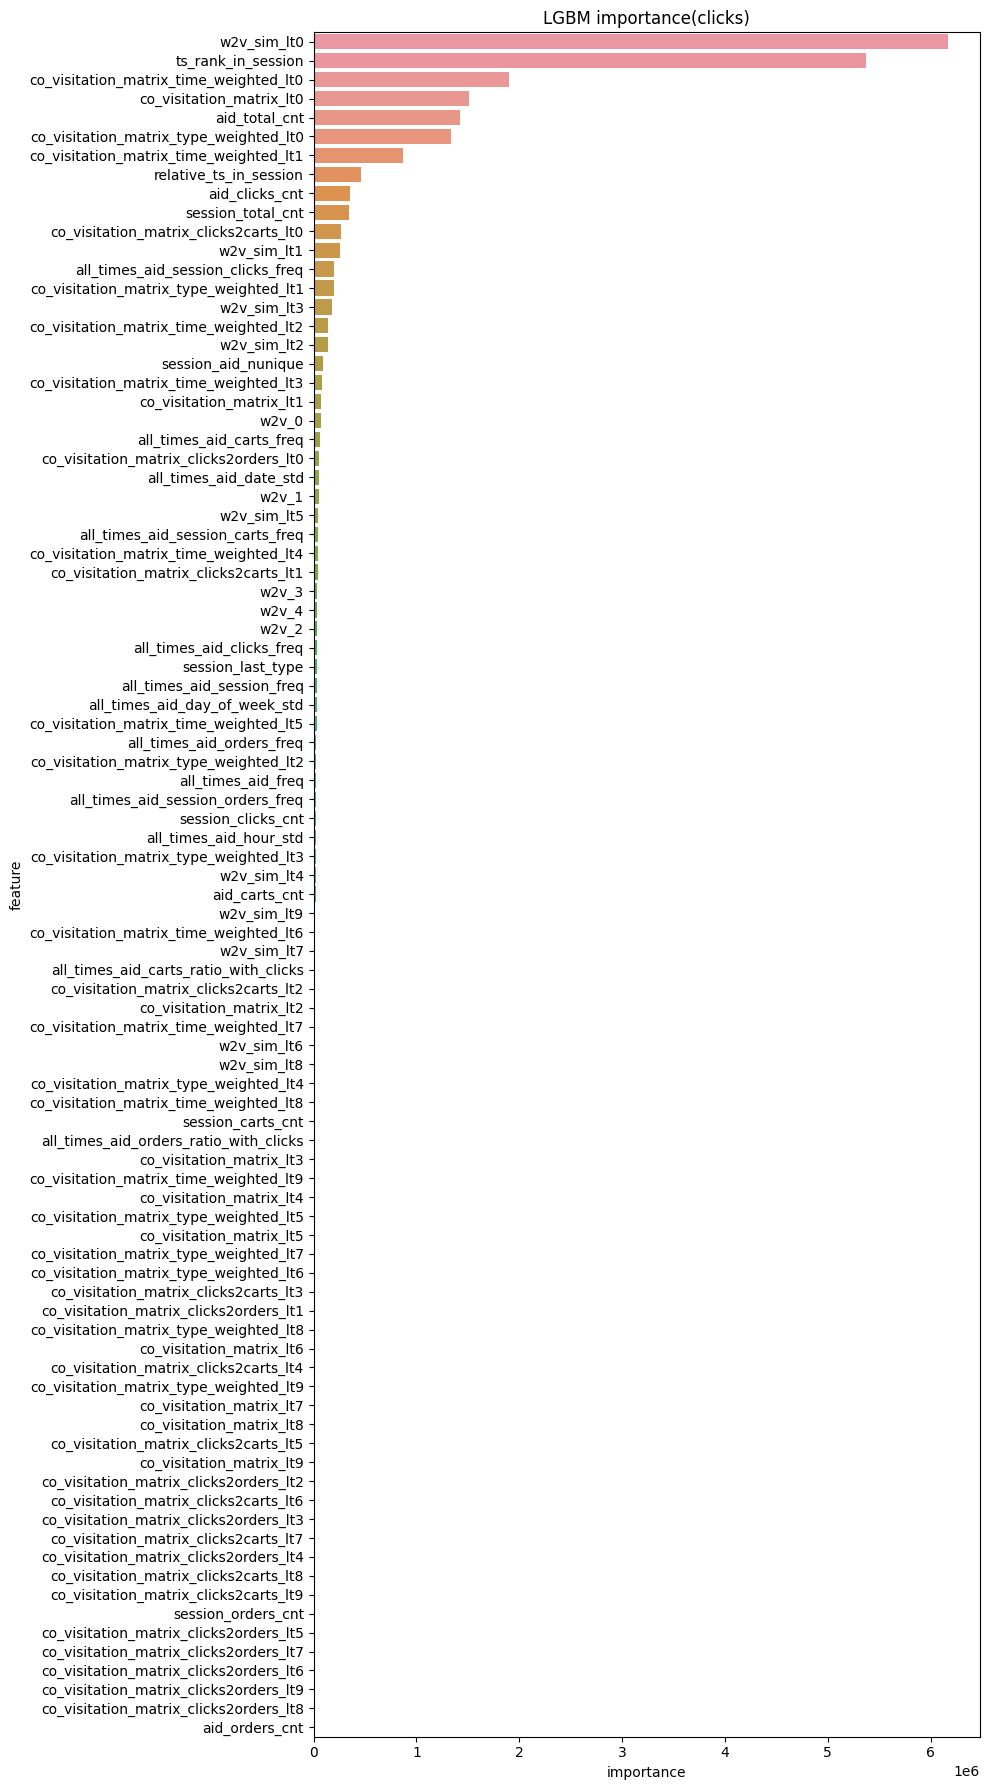

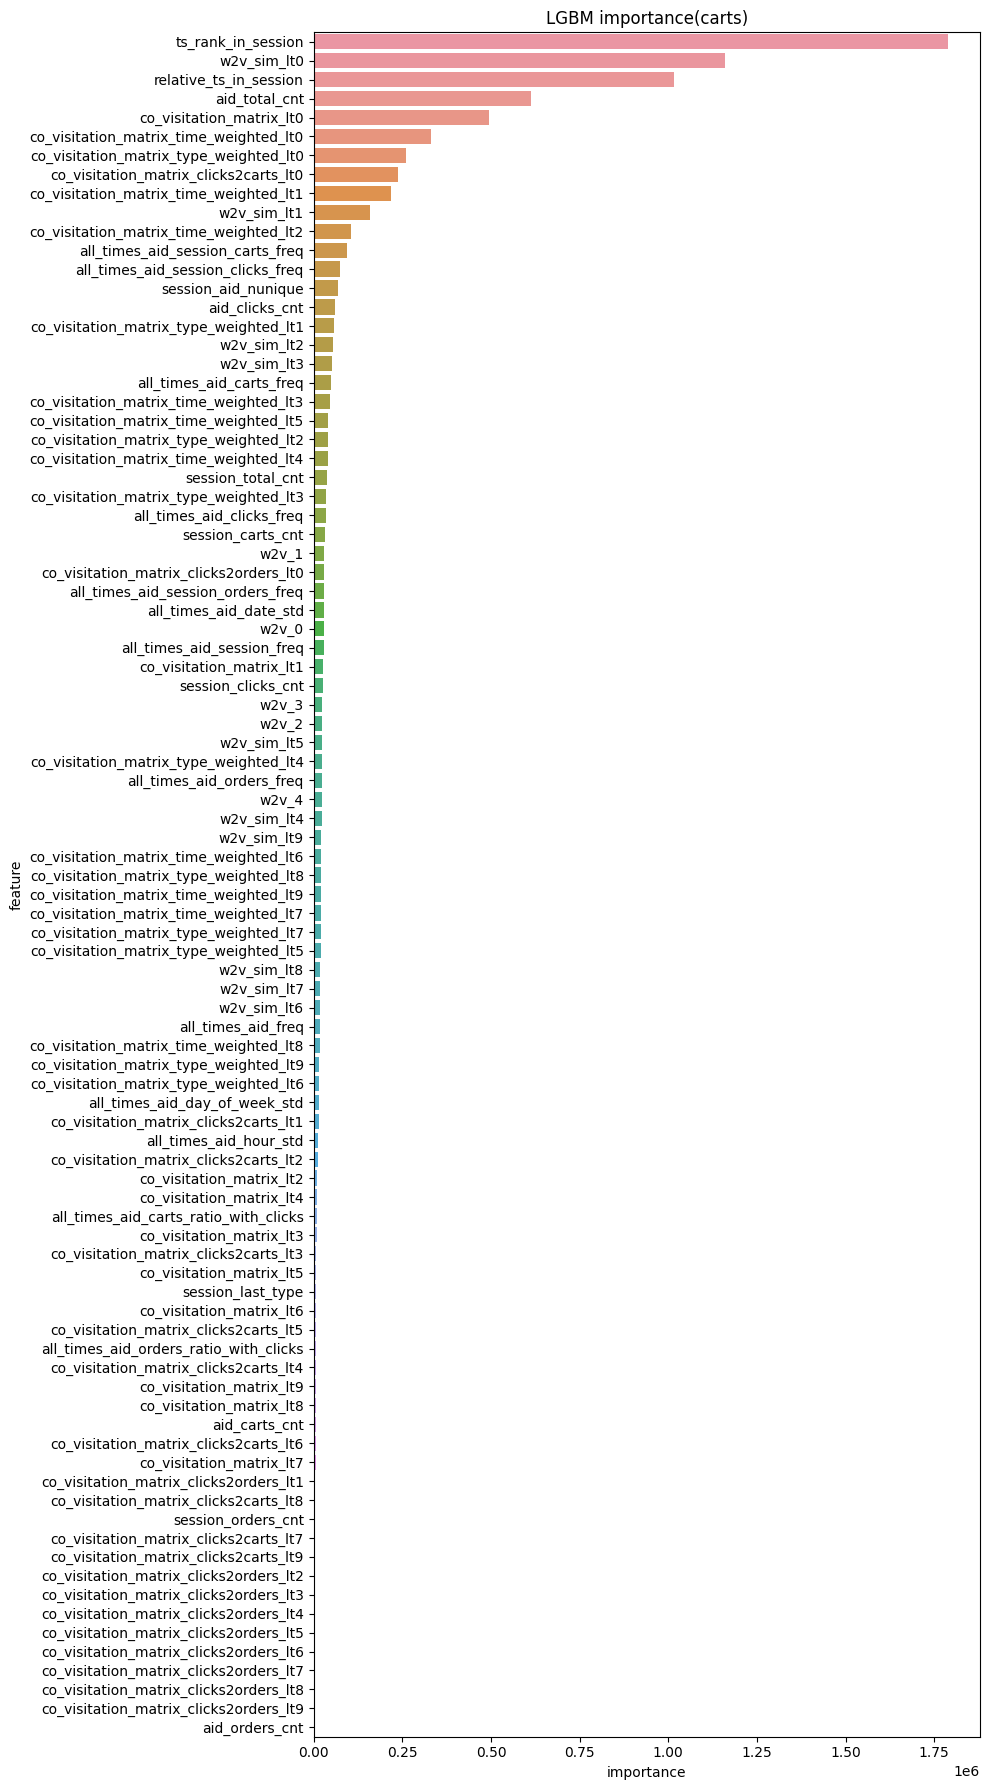

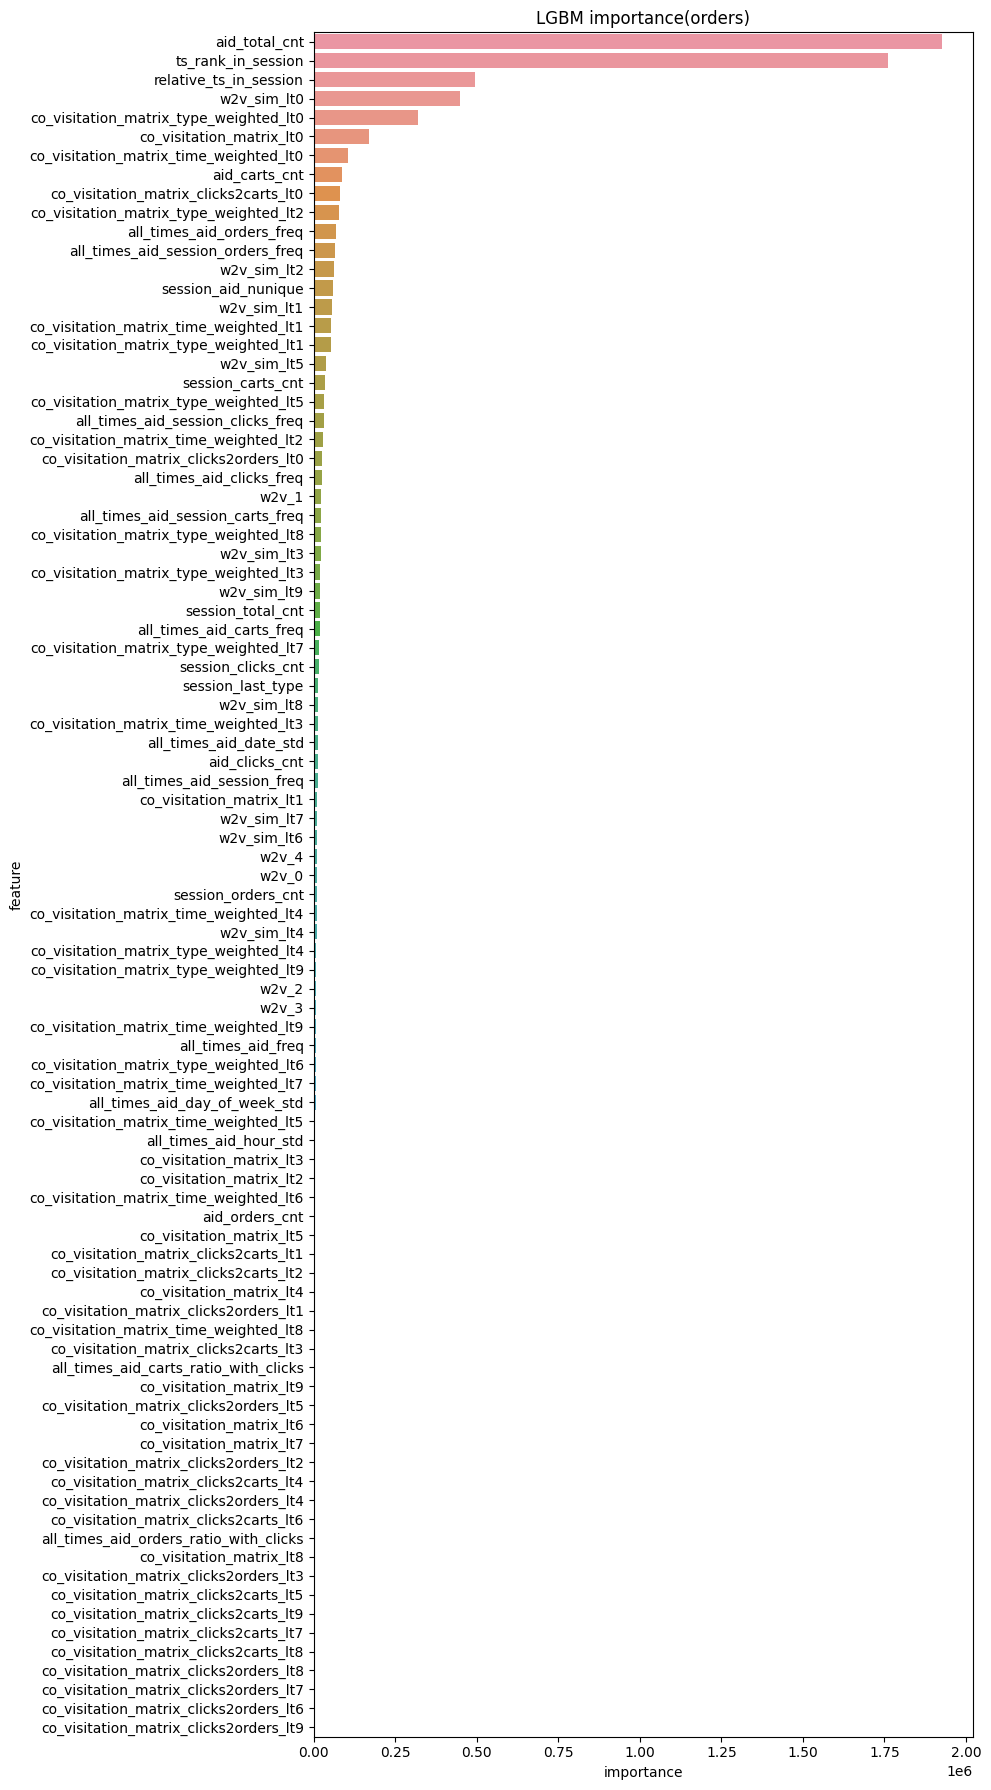

In [21]:
try:
    main()
except Exception as e:
    logger.error(traceback.format_exc())
    line_notify.send(f"{cfg.exp_name} | ERROR!!\n{traceback.format_exc()}")